# Contextuailzed Embeddings for MacBERTH
Having a dataframe of sentences that contain a term, create the contextualized embeddings of the uses of that term in the sentences with a transformers model.

Note that MacBerth is trained on data that includes CoHa

In [45]:
import os
from transformers import pipeline, AutoModelForMaskedLM, AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load the language model

In [8]:
path2model = 'emanjavacas/MacBERTh'
model = AutoModelForMaskedLM.from_pretrained(path2model)
tokenizer = AutoTokenizer.from_pretrained(path2model)

Some weights of the model checkpoint at emanjavacas/MacBERTh were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
pipe = pipeline("feature-extraction", 
                    model=model, 
                    tokenizer=tokenizer)

## Load the sentences

In [10]:
datapath = '../../sentences_out'

term = 'fair'
df_sentences = pd.read_csv(os.path.join(datapath, term+'.csv'))

In [11]:
print(df_sentences.shape)
df_sentences.head()

(425, 4)


,year,genre,id,sentence
0,1889,news,672250,Because of the revolutionary character of the ...
1,1889,news,672250,"It has been observed , of course , that the No..."
2,1889,news,672250,"Originally , the Post 's opposition to the fai..."
3,1889,news,672250,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...
4,1889,news,672250,about the fair .


(array([122., 129.,  90.,  40.,  20.,  10.,   8.,   1.,   2.,   3.]),
 array([ 16. , 103.2, 190.4, 277.6, 364.8, 452. , 539.2, 626.4, 713.6,
        800.8, 888. ]),
 <a list of 10 Patch objects>)

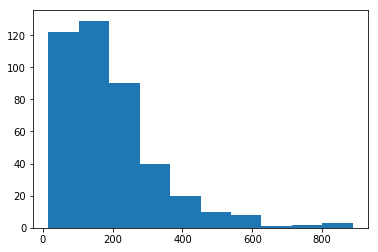

In [17]:
plt.hist([len(s) for s in df_sentences['sentence']])

In [44]:
lengths = df_sentences['sentence'].str.len()
df_sub = df_sentences[(lengths > 10) & (lengths< 300)].reset_index()
len(df_sub)

358

## Apply model to get embeddings
This will take some time to run

In [21]:
# embedding on each sentence
embeddings = pipe(list(df_sub['sentence']))

In [24]:
def get_word_embeddings(embedding, sentence, query):
    """
    Only retrieve the embeddings for the tokens that match the query
    Does not yet handle the case where query is split up in tokenization.
    """
    token_ids = tokenizer(sentence)
    tokens = tokenizer.convert_ids_to_tokens(token_ids['input_ids'])
    query_embeddings = np.array([embedding[i] for i,tok in enumerate(tokens) if tok==query])
    return query_embeddings

In [25]:
# Now do this for all sentences, and put them together in a dataframe
df_embeddings = pd.DataFrame()
for i, (_, row) in enumerate(df_sub.iterrows()):
    emb = get_word_embeddings(embeddings[i], row['sentence'], term)
    df_embeddings = df_embeddings.append(pd.DataFrame({
        'sentence': row['sentence'],
        'year': row['year'],
        'genre': row['genre'],
        'id': row['id'],
        'embedding': list(emb)}))

In [26]:
df_embeddings = df_embeddings.reset_index()

## Plot PCA

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA(n_components=2)

In [29]:
X = np.array([e for e in df_embeddings['embedding']])
X.shape

(364, 30000)

In [30]:
X_pca = pca.fit_transform(X)

In [31]:
df_embeddings['pca1'] = X_pca[:,0]
df_embeddings['pca2'] = X_pca[:,1]

Text(0.5, 1.0, 'PCA colored per genre')

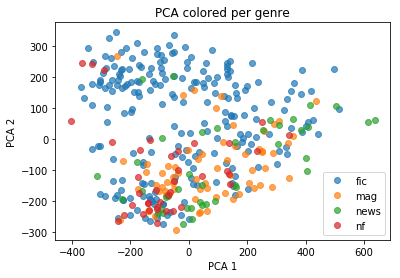

In [32]:
for key, group in df_embeddings.groupby(['genre']):
    plt.plot(group.pca1, group.pca2, 'o', alpha=0.7, label=key)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("PCA colored per genre")

Text(0.5, 1.0, 'PCA colored per year')

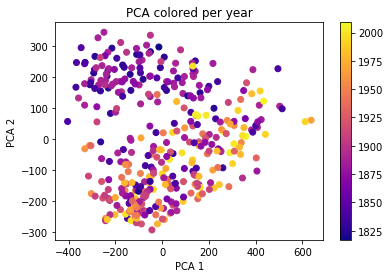

In [33]:
plt.scatter(df_embeddings['pca1'], df_embeddings['pca2'], c=df_embeddings['year'], cmap='plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.title("PCA colored per year")

In [52]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, init='pca').fit_transform(X)
df_embeddings['tsne1'] = X_tsne[:,0]
df_embeddings['tsne2'] = X_tsne[:,1]

## Masked token prediction

In [35]:
model_masked = pipeline('fill-mask',
                           model=model, 
                    tokenizer=tokenizer)

In [46]:
outputs = []

for i in tqdm(range(len(df_sub))):
    sent = df_sub['sentence'][i]
    sent_masked = sent.replace(term, '[MASK]', 1)
    output = model_masked(sent_masked)
    outputs.append(output)
    

predicted_words = [[o['token_str'] for o in output] for output in outputs]

100%|██████████| 358/358 [01:15<00:00,  5.68it/s]


In [53]:
predicted_words_df = pd.DataFrame(predicted_words, columns = ['word_{}'.format(i+1) for i in range(5)])
df = pd.concat([df_embeddings, predicted_words_df], axis=1)

In [56]:
df.to_csv('../../sentences_out/{}_embedded_macberth.csv'.format(term), index=False)

In [55]:
df.head()

,index,sentence,year,genre,id,embedding,pca1,pca2,tsne1,tsne2,word_1,word_2,word_3,word_4,word_5
0,0,Because of the revolutionary character of the ...,1889,news,672250,"[-4.602723121643066, -5.252146244049072, -1.29...",415.317530,109.641533,335.292297,94.995369,gazette,review,",",conference,revolution
1,0,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...,1889,news,672250,"[-4.4479169845581055, -6.655737400054932, -5.3...",5.776866,-224.249784,-103.621323,-315.262878,absurd,fair,ridiculous,sufficient,true
2,1,for by the astute @ @ @ @ @ @ @ @ @ @ a ' perf...,1889,news,672250,"[-5.376897811889648, -5.8108744621276855, -5.8...",407.690313,37.925565,274.842590,29.861700,end,9th,year,2,20th
3,0,about the fair .,1889,news,672250,"[-6.587862014770508, -7.782370090484619, -6.58...",502.971487,106.414820,342.672302,34.570904,school,college,museum,building,office
4,0,site for the fair mainly with a view to person...,1889,news,672250,"[-6.647197723388672, -6.510187149047852, -5.82...",382.289848,29.709689,319.490143,103.205437,highly,well,other,a,of


In [49]:
all_words = pd.concat([df['word_{}'.format(i+1)] for i in range(5)])
all_words.value_counts().head(30)

fair          152
good           80
true           32
right          30
great          27
just           26
proper         24
the            23
full           21
well           20
beautiful      18
little         17
reasonable     17
free           17
high           16
own            14
enough         14
young          14
bad            14
so             13
fine           13
large          13
lovely         12
certain        12
dear           11
a              11
sweet          11
,              11
sufficient     10
natural        10
dtype: int64